<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-definitions" data-toc-modified-id="Imports-and-definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and definitions</a></span></li><li><span><a href="#Load-tables" data-toc-modified-id="Load-tables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load tables</a></span></li><li><span><a href="#Statistics" data-toc-modified-id="Statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Statistics</a></span><ul class="toc-item"><li><span><a href="#Tweet-frequencies" data-toc-modified-id="Tweet-frequencies-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tweet frequencies</a></span></li><li><span><a href="#Summary-statistics-functions" data-toc-modified-id="Summary-statistics-functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Summary statistics functions</a></span></li><li><span><a href="#Summary-stats-for-tweets" data-toc-modified-id="Summary-stats-for-tweets-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Summary stats for <code>tweets</code></a></span></li><li><span><a href="#Summary-stats-for-user" data-toc-modified-id="Summary-stats-for-user-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Summary stats for <code>user</code></a></span></li><li><span><a href="#Analyzing-hashtags" data-toc-modified-id="Analyzing-hashtags-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Analyzing hashtags</a></span></li><li><span><a href="#Hashtags-for-highly-retweeted-items" data-toc-modified-id="Hashtags-for-highly-retweeted-items-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Hashtags for highly retweeted items</a></span></li><li><span><a href="#Linking-mention-to-the-user-table" data-toc-modified-id="Linking-mention-to-the-user-table-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Linking <code>mention</code> to the <code>user</code> table</a></span></li><li><span><a href="#Summary-stats-for-mention" data-toc-modified-id="Summary-stats-for-mention-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Summary stats for <code>mention</code></a></span></li></ul></li></ul></div>

# Analysis 1

## Imports and definitions

In [1]:
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') #Generally nice
from pandasql import sqldf
sql = lambda x: sqldf(x, globals())

## Load tables

In [2]:
path = 'output_data/'
tweet = pd.read_csv(path+'tweet.csv', lineterminator='r')
user = pd.read_csv(path+'user.csv')
hashtag = pd.read_csv(path+'hashtag.csv')
mention = pd.read_csv(path+'mention.csv')
tweet_hashtag = pd.read_csv(path+'tweet_hashtag.csv')
tweet_mention = pd.read_csv(path+'tweet_mention.csv')

## Statistics
### Tweet frequencies

In [3]:
# Simple tweet frequencies
tweet_freq_hour = sql('''
SELECT  strftime('%H', created_at) AS hour, count(*) AS cnt
FROM tweet
GROUP BY hour;
''')


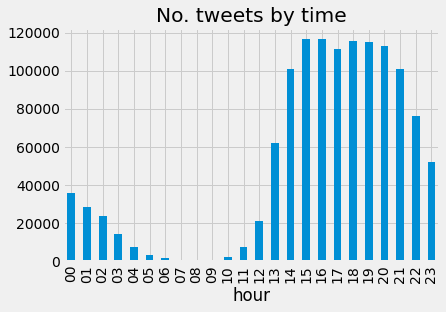

In [4]:
tweet_freq_hour.plot(kind='bar',legend=None, title='No. tweets by time', x='hour')

These times are given in UTC, which is fine, but reminded me to take account of DST which in the US runs from the second Sunday in March to the first Sunday in November.  I estimated these to be 11 Mar and 4 Nov respectively.

In [5]:
# Tweet frequencies DST and non-DST
tweet_freq_hour_winter = sql('''
SELECT  strftime('%H', created_at) AS hour, count(*) AS cnt
FROM tweet
-- Allocate each consecutive day an increasing number, then figure out what
-- day number corresponds to the approx. start and end of DST
-- 3*32+11 = 107, 11*32+4 = 356
WHERE   CAST(strftime('%m', created_at) AS INT)*32
        +CAST(strftime('%d', created_at) AS INT) <= 107
        OR
        CAST(strftime('%m', created_at) AS INT)*32
        +CAST(strftime('%d', created_at) AS INT) >= 356
GROUP BY hour;
''')
tweet_freq_hour_summer = sql('''
SELECT  strftime('%H', created_at) AS hour, count(*) AS cnt
FROM tweet
-- Allocate each consecutive day an increasing number, then figure out what
-- day number corresponds to the approx. start and end of DST
-- 3*32+11 = 107, 11*32+4 = 356
WHERE   CAST(strftime('%m', created_at) AS INT)*32
        +CAST(strftime('%d', created_at) AS INT) > 107
        AND
        CAST(strftime('%m', created_at) AS INT)*32
        +CAST(strftime('%d', created_at) AS INT) < 356
GROUP BY hour;
''')

The politicians we are interested in are mostly based in DC which is UTC-05.

In [6]:
# Convert from UTC to Eastern Time
tweet_freq_hour_winter['hour'] = [str(x) for x in range(19,24)]+\
                                 ['0'+str(x) for x in range(10)]+\
                                 [str(x) for x in range(10,19)]

tweet_freq_hour_summer['hour'] = [str(x) for x in range(20,24)]+\
                                 ['0'+str(x) for x in range(10)]+\
                                 [str(x) for x in range(10,20)]
tweet_freq_hour_winter = tweet_freq_hour_winter.sort_values(by='hour').set_index('hour')
tweet_freq_hour_summer = tweet_freq_hour_summer.sort_values(by='hour').set_index('hour')
#Reuse this variable
tweet_freq_hour = tweet_freq_hour_summer + tweet_freq_hour_winter
tweet_freq_hour.reset_index(inplace=True)
# Refactor to allow arbitrary time change?

<BarContainer object of 24 artists>

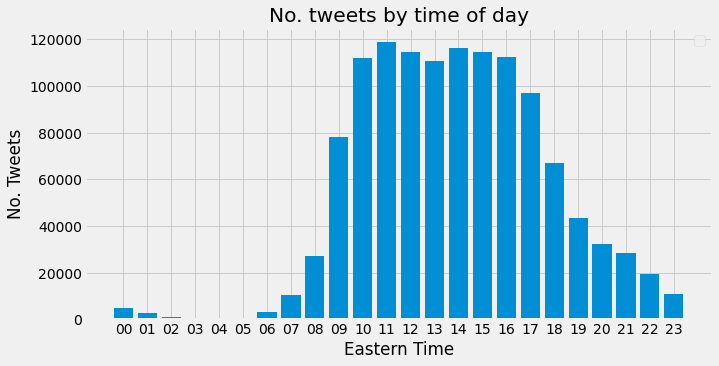

In [7]:
plt.figure(figsize=(10,5))
plt.title('No. tweets by time of day')
plt.legend('')
plt.xlabel('Eastern Time')
plt.ylabel('No. Tweets')
plt.bar(tweet_freq_hour['hour'], tweet_freq_hour['cnt'])

Tweets rocket up at 9am so for tweets to be noticed they should be sent
around 8am so that they are more likely to be seen by our targets as they will
be more recent.

#### Political tweets over time

In [8]:
def get_tweets_yearly(start_year=2016, end_year=2016):
    query = f'''
        SELECT SUBSTR(
                   DATE(t.created_at,'start of month'),
                   1,7) AS month,
                COUNT(*) AS frequency
        FROM tweet AS t
        WHERE CAST(STRFTIME('%Y',t.created_at) AS INT) >= {start_year}
                AND
              CAST(STRFTIME('%Y',t.created_at) AS INT) <= {end_year}
        GROUP BY month
        ORDER BY month
        ;'''
    return sql(query)

In [9]:
df = get_tweets_yearly(2008,2017)

Text(0.5, 1.0, 'Tweet volume by time')

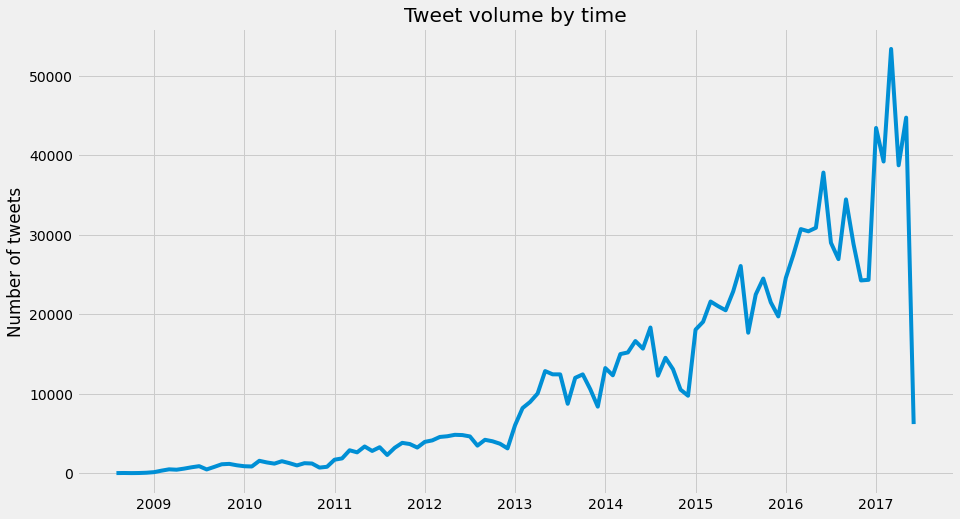

In [10]:
plt.figure(num=1,figsize=(14,8))
plt.plot(df.month, df.frequency)
plt.xticks(range(5, 110, 12), range(2009, 2018))
plt.ylabel('Number of tweets')
plt.title('Tweet volume by time')

### Summary statistics functions

In [11]:
def descriptive (table, column):
    count = sql(f'''
        SELECT "Count" AS statistic,
                count({column}) AS value
        FROM {table};
        ''')
    mean = sql(f'''
        SELECT "Mean" AS statistic,
                ROUND(AVG({column}), 2) AS value
        FROM {table};
        ''')
    median = sql(f'''
        SELECT "Median" AS statistic,
                {column} AS value
        FROM {table}
        ORDER BY {column}
        LIMIT 1
        OFFSET (SELECT COUNT(*) FROM {table})/2;
        ''')
    #Use a subquery to give mode two columns like the others
    mode = sql(f'''
        SELECT statistic, value
            FROM(
            SELECT "Mode" AS statistic,
                    {column} AS value,
                    COUNT(*)
            FROM {table}
            GROUP BY {column}
            ORDER BY COUNT(*) DESC
            LIMIT 1);
    ''')
    minimum = sql(f'''
        SELECT "Min" AS statistic,
                MIN({column}) AS value
        FROM {table}
    ''')
    maximum = sql(f'''
        SELECT "Max" AS statistic,
                MAX({column}) AS value
        FROM {table}
    ''')
    stdev = sql(f'''
        SELECT "Standard deviation" AS statistic,
                SUM(sqd) AS value
        FROM(
            SELECT ({table}.{column} - xavg.xbar) *
                    ({table}.{column} - xavg.xbar)/xavg.n AS sqd
            FROM {table},
                (SELECT
                    AVG({column}) AS xbar,
                    COUNT({column}) AS n
                FROM {table}) AS xavg);
    ''')
    # Take square root to calculate stdev.  Not possible in SQLite.
    stdev.iloc[0,1] = np.sqrt(stdev.iloc[0,1])
    stats = pd.concat([count, mean, stdev, median,
                       mode, minimum, maximum]).set_index('statistic')
    return stats

In [12]:
def get_iqrs (table, column):
    query = f"""
WITH
percent_tbl AS
    (SELECT {column},
            NTILE(4) OVER(ORDER BY {column}) AS percent
     FROM {table}),
p_0 AS (
    SELECT (0) AS percentile,
        MIN({column}) last_val
    FROM percent_tbl),
p_25 AS (
    SELECT (percent*25) AS percentile,
            LAST_VALUE({column}) OVER (PARTITION BY percent) last_val
    FROM percent_tbl
    WHERE percent=1
    LIMIT 1),
p_50 AS (
    SELECT (percent*25) AS percentile,
            LAST_VALUE({column}) OVER (PARTITION BY percent) last_val
    FROM percent_tbl
    WHERE percent=2
    LIMIT 1),
p_75 AS (
    SELECT (percent*25) AS percentile,
            LAST_VALUE({column}) OVER (PARTITION BY percent) last_val
    FROM percent_tbl
    WHERE percent=3
    LIMIT 1),
p_100 AS (
    SELECT (percent*25) AS percentile,
            LAST_VALUE({column}) OVER (PARTITION BY percent) last_val
    FROM percent_tbl
    WHERE percent=4
    LIMIT 1)
SELECT * FROM p_0 UNION
SELECT * FROM p_25 UNION
SELECT * FROM p_50 UNION
SELECT * FROM p_75 UNION
SELECT * FROM p_100;
"""
    iqrs = sql(query)
    return iqrs

### Summary stats for `tweets`

In [13]:
%%time
for col in tweet.columns:
    print('='*50)
    print(f'Descriptive statistics for tweet.{col}')
    print('='*50)
    display(descriptive('tweet',col))
    display(get_iqrs('tweet',col).style.hide_index())

Descriptive statistics for tweet.created_at


,value
statistic,
Count,1226949
Mean,2014.99
Standard deviation,1.70
Median,2015-11-05 04:31:32
Mode,2015-02-06 15:42:07
Min,2008-08-04 17:28:51
Max,2017-06-06 17:16:00


percentile,last_val
0,2008-08-04 17:28:51
25,2014-06-11 14:42:51
50,2015-11-05 04:31:32
75,2016-09-28 16:29:02
100,2017-06-06 17:16:00


Descriptive statistics for tweet.id


,value
statistic,
Count,1226949.00
Mean,609487441012720256.00
Standard deviation,213953496225577536.00
Median,662125066025574400.00
Mode,872140026737336320.00
Min,877418565.00
Max,872140026737336320.00


percentile,last_val
0,877418565
25,476736323265777664
50,662125066025574400
75,781168853250404352
100,872140026737336320


Descriptive statistics for tweet.retweet_count


,value
statistic,
Count,1226949.00
Mean,190.30
Standard deviation,10005.70
Median,4.00
Mode,1.00
Min,0.00
Max,3637896.00


percentile,last_val
0,0
25,1
50,4
75,10
100,3637896


Descriptive statistics for tweet.screen_name


,value
statistic,
Count,1226949
Mean,0.00
Standard deviation,0.00
Median,RepLukeMesser
Mode,MassGovernor
Min,AkGovBillWalker
Max,virginiafoxx


percentile,last_val
0,AkGovBillWalker
25,RepAnnieKuster
50,RepLukeMesser
75,SenJohnMcCain
100,virginiafoxx


Descriptive statistics for tweet.text


,value
statistic,
Count,1226947
Mean,-0.01
Standard deviation,11.11
Median,"I posted photos on Facebook in the album ""USO Care Packages, May """
Mode,Happy birthday !
Min,! ! RT : The Razorbacks have arrived in Albuquerque
Max,~because I'm happy~ happiest city in the whole USA you're b happier next time


percentile,last_val
0,! ! RT : The Razorbacks have arrived in Albuquerque
25,: warns fishing fleet heading into weekend; forecasts life threatening temps/chills http
50,"I posted photos on Facebook in the album ""USO Care Packages, May """
75,"So grateful for the grace, strength & perseverance of Doherty family for the past years as they sought this justice for their fallen son"
100,~because I'm happy~ happiest city in the whole USA you're b happier next time


CPU times: user 5min 12s, sys: 16.4 s, total: 5min 28s
Wall time: 5min 30s


The high maximum and standard deviation of `retweet_count` initially made me suspect an error.  It turns out that the number of tweets, while almost always low is *highly* negatively skewed and there is a long tail of very high retweet values.

However most politicians' tweets are retweeted once and around 50% of tweets are retweeted more than 4 times.

|n      |mean |mode|min|Q1|median|Q3|max    |IQR|stdev|
|-------|-----|----|---|--|------|--|-------|---|-----|
|1226949|190.3|4   |0  |1 |4     |10|3637896|9  |10006|

It *might* be worthwhile setting a threshold for 'large' tweets (say the 99th percentile) and looking for traits that these tweets have in common.  I suspect that many of them will rely on the person tweeting which does not help significantly with broadening our audience as we will already be targetting these top figures.

There is far less than a full month worth of tweets in June 2017 which distorted the graph of tweet volumes above.
I will remove these and redraw the graph of tweet volumes.  Also put in a regression line!

In [14]:
def get_tweets_yearly(start_year=2008, end_year=2017):
    query = f'''
        SELECT SUBSTR(
                   DATE(t.created_at,'start of month'),
                   1,7) AS month,
                COUNT(*) AS frequency
        FROM (
            SELECT created_at
            FROM tweet
            WHERE created_at < DATE("2017-06-01")
            ) AS t
        WHERE CAST(STRFTIME('%Y',t.created_at) AS INT) >= {start_year}
                AND
              CAST(STRFTIME('%Y',t.created_at) AS INT) <= {end_year}
        GROUP BY month
        ORDER BY month
        ;'''
    return sql(query)

In [15]:
# The number of tweets seems to be linear from 2013 onwards
df = get_tweets_yearly(2013,2017)

In [16]:
# Create simple regression model
y = df['frequency'].values
df['month_number']=np.arange(len(df))
x = df['month_number'].values
x = sm.add_constant(x)
model = sm.OLS(y, x, hasconst=True).fit()
# Make a line
a = model.params[0]
b = model.params[1]
pred = []
for i in x:
    pred.append(a+b*i[1])
df['yhat'] = pred

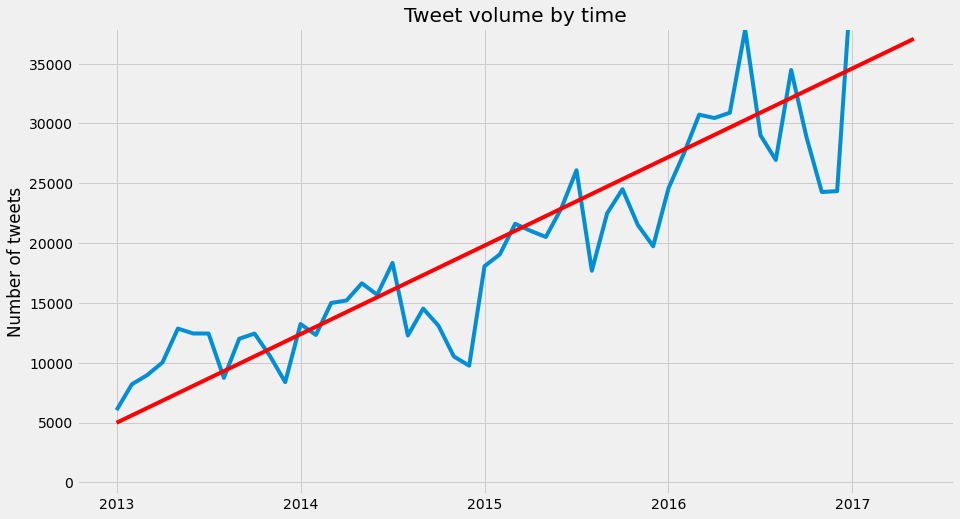

In [17]:
plt.figure(num=1,figsize=(14,8))
plt.ylabel('Number of tweets')
plt.title('Tweet volume by time')
plt.xticks(range(0, 110, 12), range(2013, 2018))
plt.ylim([-1000,38000])
plt.yticks(range(0,36001,5000))
plt.plot(df.month, df.frequency)
plt.plot(df.month, df.yhat, color='red')

### Summary stats for `user`

In [18]:
%%time
for col in user.columns:
    print('='*50)
    print(f'Descriptive statistics for user.{col}')
    print('='*50)
    display(descriptive('user',col))
    display(get_iqrs('user',col).style.hide_index())

Descriptive statistics for user.created_at


,value
statistic,
Count,548
Mean,2011.48
Standard deviation,2.53
Median,2011-02-04
Mode,2017-01-03
Min,2007-04-27
Max,2017-04-19


percentile,last_val
0,2007-04-27
25,2009-07-15
50,2011-02-03
75,2013-02-22
100,2017-04-19


Descriptive statistics for user.description


,value
statistic,
Count,539
Mean,0.55
Standard deviation,5.20
Median,Proud Husband | Father | @Cavs @Indians @Browns Fan | Congressman for Ohio’s 13th District
Mode,None
Min,"#IL05 Congressman, House Appropriator, member of Intel Committee, amateur hockey player & hopeful Cubs fan http://t.co/zL9fkzy188 http://t.co/FMe57EKfsC"
Max,"proud husband, father, grandfather; humble Rep. of VA's 1st District; Seapower and Projection Forces Subcommittee Chair; advocate of sportsman-led conservation"


percentile,last_val
0,"#IL05 Congressman, House Appropriator, member of Intel Committee, amateur hockey player & hopeful Cubs fan http://t.co/zL9fkzy188 http://t.co/FMe57EKfsC"
25,I am proud to represent Alabama's Third Congressional District.
50,Proud Granite Stater serving New Hampshire in the US Senate. Former Governor. Mother & Grandmother. Frequent Flyer. Pats & Red Sox Fan. Outdoor enthusiast.
75,Representing the State of Texas in the United States Senate.
100,"proud husband, father, grandfather; humble Rep. of VA's 1st District; Seapower and Projection Forces Subcommittee Chair; advocate of sportsman-led conservation"


Descriptive statistics for user.followers_count


,value
statistic,
Count,548.00
Mean,163433.91
Standard deviation,1595898.91
Median,16774.00
Mode,8437.00
Min,4.00
Max,31712585.00


percentile,last_val
0,4
25,8862
50,16690
75,33042
100,31712585


Descriptive statistics for user.friends_count


,value
statistic,
Count,548.00
Mean,2033.73
Standard deviation,6272.70
Median,755.00
Mode,0.00
Min,0.00
Max,92934.00


percentile,last_val
0,0
25,365
50,748
75,1668
100,92934


Descriptive statistics for user.name


,value
statistic,
Count,548
Mean,0.00
Standard deviation,0.00
Median,Rep Josh Gottheimer
Mode,tiberipress
Min,(((Rep. Nadler)))
Max,tiberipress


percentile,last_val
0,(((Rep. Nadler)))
25,Governor Tom Wolf
50,Rep John Duncan Jr.
75,Rep. Trent Franks
100,tiberipress


Descriptive statistics for user.screen_name


,value
statistic,
Count,548
Mean,0.00
Standard deviation,0.00
Median,RepLouCorrea
Mode,virginiafoxx
Min,AkGovBillWalker
Max,virginiafoxx


percentile,last_val
0,AkGovBillWalker
25,RepBarragan
50,RepLouBarletta
75,SenCapito
100,virginiafoxx


Descriptive statistics for user.total_tweets


,value
statistic,
Count,548.00
Mean,3658.96
Standard deviation,4255.39
Median,2686.00
Mode,3583.00
Min,0.00
Max,59535.00


percentile,last_val
0,0
25,1380
50,2682
75,4508
100,59535


CPU times: user 525 ms, sys: 307 µs, total: 526 ms
Wall time: 518 ms


### Analyzing hashtags

The best way to count these will be through the `tweet_hashtag` table as the `hashtag` table itself contains only the unique hashtags.

In [19]:
def top_n(table, column, n=10):
    query = f'''
    SELECT {column},
    COUNT(*) AS frequency
    FROM {table}
    GROUP BY {column}
    ORDER BY COUNT(*) DESC
    LIMIT {n};
    '''
    return sql(query)

In [20]:
def timing(table, column, text):
    query = f'''
    SELECT COUNT(*) AS frequency,
           SUBSTR(
               DATE(t.created_at,'start of month'),
               1,7) AS month
    FROM {table}
    INNER JOIN tweet AS t
        ON t.id = {table}.tweet_id
    WHERE {column} = "{text}"
    GROUP BY month
    ORDER BY month
    '''
    return sql(query)

Test this with some of the more popular hashtags

In [21]:
%%time
hashtag_graph = timing('tweet_hashtag','hashtag','SCOTUS')

CPU times: user 10.2 s, sys: 531 ms, total: 10.7 s
Wall time: 10.7 s


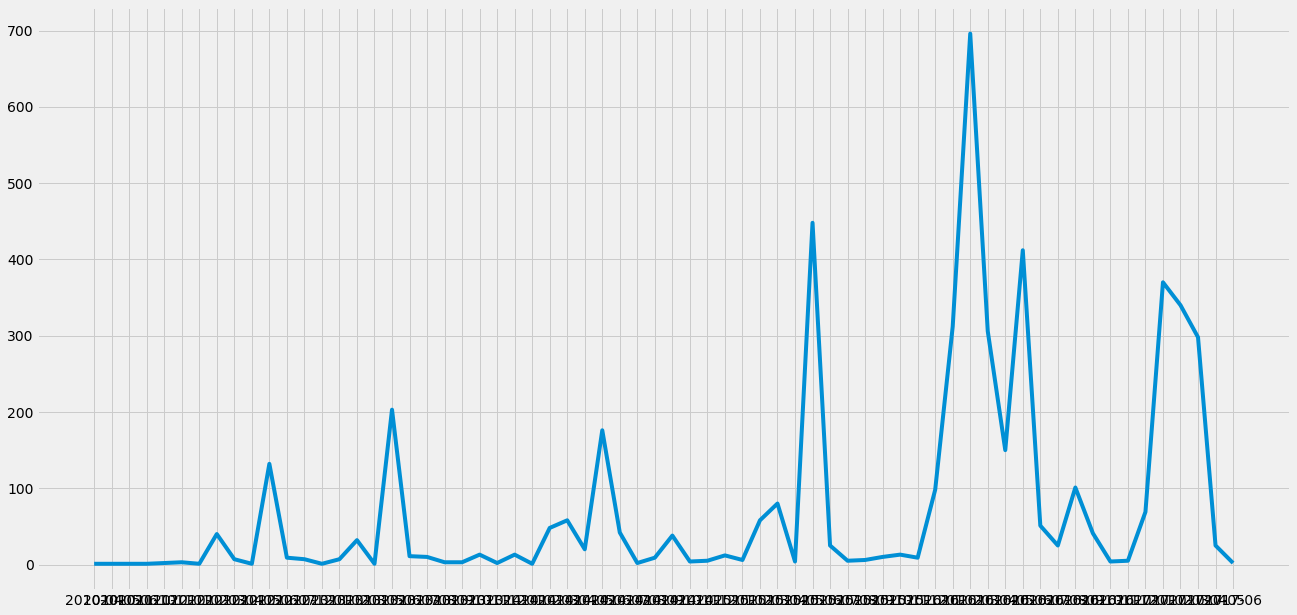

In [22]:
plt.figure(num=1,figsize=(20,10))
plt.plot(hashtag_graph.month, hashtag_graph.frequency)

In [23]:
n=20
topn=top_n("tweet_hashtag","hashtag",n=n)
print('Rank', 'Hashtag', 'Frequency',sep='|')
print('----', '-------', '---------',sep='|')
for i in range(n):
    print(i+1, topn['hashtag'].iloc[i], topn['frequency'].iloc[i], sep='|')

Rank|Hashtag|Frequency
----|-------|---------
1|Obamacare|11086
2|tcot|7951
3|ACA|6143
4|SOTU|5939
5|SCOTUS|4889
6|utpol|4758
7|mepolitics|4564
8|jobs|4037
9|veterans|3671
10|4jobs|3339
11|IRS|3230
12|GOP|3226
13|Trumpcare|2741
14|Zika|2599
15|immigration|2586
16|ObamaCare|2579
17|Iran|2482
18|DoYourJob|2445
19|IranDeal|2432
20|smallbiz|2396


Rank|Hashtag|Frequency
----|-------|---------
1|Obamacare|11086
2|tcot|7951
3|ACA|6143
4|SOTU|5939
5|SCOTUS|4889
6|utpol|4758
7|mepolitics|4564
8|jobs|4037
9|veterans|3671
10|4jobs|3339
11|IRS|3230
12|GOP|3226
13|Trumpcare|2741
14|Zika|2599
15|immigration|2586
16|ObamaCare|2579
17|Iran|2482
18|DoYourJob|2445
19|IranDeal|2432
20|smallbiz|2396

The most common hashtag is Obamacare/ACA.  tcot is an old hashtag which is not much used.

How do hashtags change over time ie.e can we graph month/year against usage?

<BarContainer object of 20 artists>

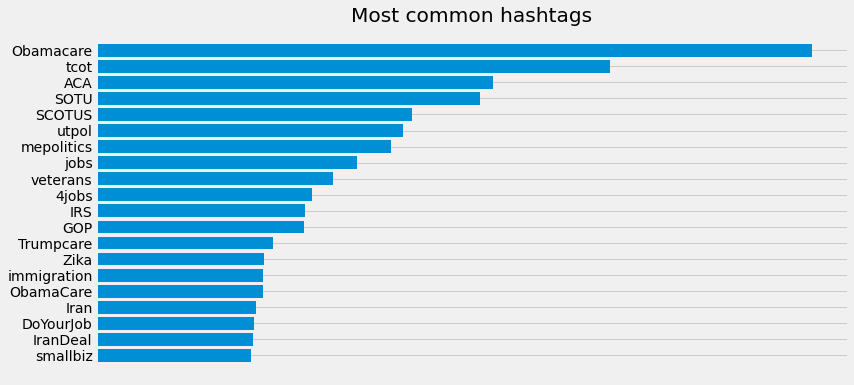

In [24]:
plt.figure(figsize=(12,6))
plt.title('Most common hashtags')
plt.xticks([])
topn.sort_values(by='frequency', inplace=True)
plt.barh(topn['hashtag'], topn['frequency'])

### Hashtags for highly retweeted items

In [25]:
def popular_hashtags(min_retweets = 1000,
                     start_date = '2008-08-04', #By default the whole dataset
                     end_date = '2017-06-06'):
    query = f'''
-- Retrieve just the most popular tweets
WITH pop AS
   (SELECT  t.retweet_count,
            t.id
    FROM
        tweet AS t
    WHERE
        t.retweet_count >= {min_retweets}
        AND
        t.created_at <= "{end_date}"
        AND
        t.created_at >= "{start_date}"
    )
SELECT h.hashtag,
        SUM(1) AS hashtag_uses
FROM
    pop
INNER JOIN
    tweet_hashtag AS h
ON
    pop.id = h.tweet_id
GROUP BY h.hashtag
ORDER BY SUM(1) DESC
'''
    return sql(query)

In [26]:
%%time
topn = popular_hashtags(10000).head(20)

CPU times: user 9.84 s, sys: 460 ms, total: 10.3 s
Wall time: 10.3 s


<BarContainer object of 20 artists>

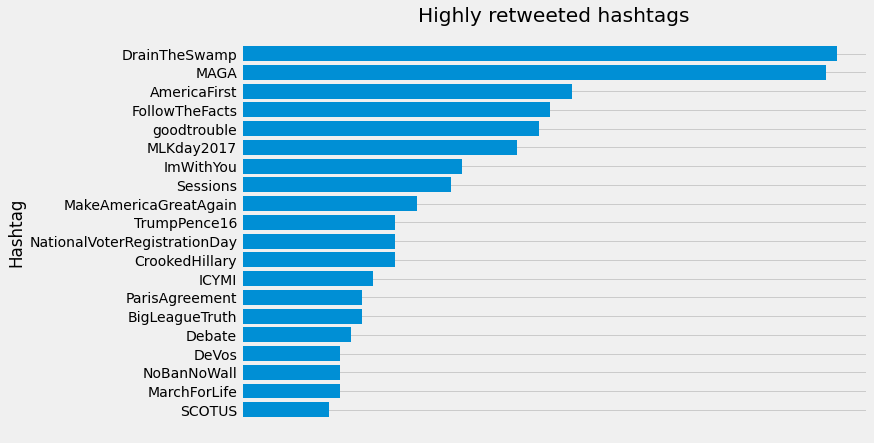

In [27]:
plt.figure(figsize=(10,7))
plt.title('Highly retweeted hashtags')
plt.xticks([])
plt.ylabel('Hashtag')
topn.sort_values(by='hashtag_uses', inplace=True)
plt.barh(topn['hashtag'], topn['hashtag_uses'])

### Linking `mention` to the `user` table

In [28]:
def most_followed(n = 10,
                  start_date = '2008-08-04', #By default the whole dataset
                  end_date = '2017-06-06'):
    query = f'''
    SELECT  h.hashtag,
            SUM(1) AS frequency
    FROM(
        SELECT screen_name
        FROM user
        ORDER BY followers_count DESC
        LIMIT {n}) AS topn
    INNER JOIN
        tweet t
    ON
        t.screen_name = topn.screen_name
    INNER JOIN
        tweet_hashtag h
    ON
        h.tweet_id = t.id
    WHERE
        t.created_at >= '{start_date}'
        AND
        t.created_at <= '{end_date}'
    GROUP BY
        h.hashtag
    ORDER BY
        frequency DESC
    LIMIT 20;
        '''
    return sql(query)

In [29]:
%%time
followed_tags = most_followed(user.shape[0]//10, start_date='2016-01-01') #Most followed tweeters, top 10%

CPU times: user 12.2 s, sys: 1.32 s, total: 13.5 s
Wall time: 13.5 s


<BarContainer object of 20 artists>

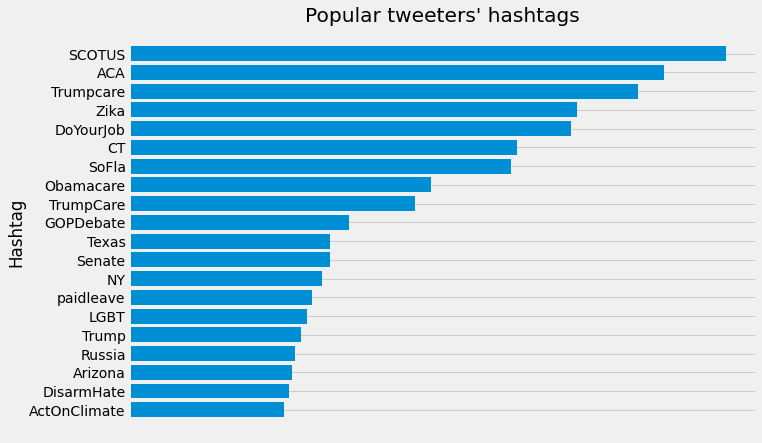

In [30]:
plt.figure(figsize=(10,7))
plt.title('Popular tweeters\' hashtags')
plt.xticks([])
plt.ylabel('Hashtag')
followed_tags.sort_values(by='frequency', inplace=True)
plt.barh(followed_tags['hashtag'], followed_tags['frequency'])

### Summary stats for `mention`

For the same reason as above we'll using `tweet_mention`.

In [31]:
top_n('tweet_mention','mention')

,mention,frequency
0,POTUS,14144
1,HouseGOP,10949
2,realDonaldTrump,6920
3,SpeakerRyan,5583
4,SpeakerBoehner,4423
5,WhiteHouse,4400
6,HouseDemocrats,4037
7,FoxNews,3713
8,HouseCommerce,3691
9,GOPoversight,3013
